In [1]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
import spacy
from tqdm import tqdm
import copy
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
!wget https://raw.githubusercontent.com/owncodezs/Cyberbullying-classification/main/Tamil/Test.csv
!wget https://raw.githubusercontent.com/owncodezs/Cyberbullying-classification/main/Tamil/train.csv
!wget https://raw.githubusercontent.com/Natkeeran/automated_tamil_text_classification/master/data/TamilNLP_TamilStopWords.txt
!wget https://raw.githubusercontent.com/Natkeeran/automated_tamil_text_classification/master/data/custom_tamil_stop_words.txt


--2023-08-18 18:13:49--  https://raw.githubusercontent.com/owncodezs/Cyberbullying-classification/main/Tamil/Test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217900 (213K) [text/plain]
Saving to: ‘Test.csv’

Test.csv            100%[===================>] 212.79K  --.-KB/s    in 0.02s   

2023-08-18 18:13:50 (8.42 MB/s) - ‘Test.csv’ saved [217900/217900]

--2023-08-18 18:13:50--  https://raw.githubusercontent.com/owncodezs/Cyberbullying-classification/main/Tamil/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1859

In [3]:
# import os

# # Create a folder to store the downloaded files
# folder_path = "/content/tamil_wiki_data"
# os.makedirs(folder_path, exist_ok=True)

# for i in range(22):
#     url = f"https://raw.githubusercontent.com/Natkeeran/automated_tamil_text_classification/master/data/tamil_wiki_data/wiki_{str(i).zfill(2)}"
#     file_path = os.path.join(folder_path, f"wiki_{str(i).zfill(2)}")
#     !wget -P $folder_path $url

In [3]:
train_set = pd.read_csv("/content/train.csv",
                   encoding = "utf-8",
                   engine = "python",
                   header = 0)

test_set = pd.read_csv("/content/Test.csv",
                   encoding = "utf-8",
                   engine = "python",
                   header = 0)


In [4]:
train_set.head()

,id,text,category
0,tam1,திருமலை நாயக்கர் பேரவை சார்பாக படம் வெற்றி பெற...,NOT
1,tam2,இந்த ட்ரெய்லர் கூட பார்க்கிற மாதிரி இல்லை.. இத...,OFF
2,tam3,மைசூரு செட்டியார் சமூகத்தின் சார்பாக இப்படம் வ...,NOT
3,tam4,மொத்த சாதியும் ஒரு சாதிக்கு எதிரா நிக்குது.......,OFF
4,tam5,only for விஜய் சேதுபதி and STR,NOT


In [5]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        654 non-null    object
 1   text      654 non-null    object
 2   category  654 non-null    object
dtypes: object(3)
memory usage: 15.5+ KB


In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [7]:
def take_data_to_shower(tweet):
    tweet=str(tweet)

    noises = ['URL', '@USER', '\'ve', 'n\'t', '\'s', '\'m']

    for noise in noises:
        tweet = tweet.replace(noise, '')

    return tweet

In [8]:
def remove_emoticon(text):
        text=str(text)

        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

In [9]:
def remove_punc(text):
    text=str(text)
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

In [10]:
def tokenize(tweet):
   tweet=str(tweet)
#
   lower_tweet = tweet.lower()
   return word_tokenize(lower_tweet)

In [11]:
def get_tamil_stop_words():
    swdf1 = pd.read_csv("TamilNLP_TamilStopWords.txt",  header=None)
    swdf2 = pd.read_csv("custom_tamil_stop_words.txt",  header=None)
    sw1 = swdf1[0].tolist()
    sw2 = swdf2[0].tolist()
    tamil_stop_words = list(set(sw1 + sw2))
    return tamil_stop_words

In [12]:
def remove_stop_words(tokens):
   clean_tokens = []
   newStopWords = get_tamil_stop_words()
#    newStopWords = [
#     "ஒரு", "இது", "அது", "அவர்", "நான்",
#     "நீங்கள்", "அவன்", "அவள்", "நமக்கு", "உங்களுக்கு",
#     "அவர்களுக்கு", "அவர்கள்", "அதில்", "இங்கு", "எப்போது",
#     "எப்படி", "என்னை", "உள்ள", "என்னுடைய", "உங்கள்",
#     "எமது", "இதை", "அந்த", "பொது", "மிகுந்த"
# ]
   stopWords = stopwords.words('english')
   stopWords.append(newStopWords)
  #  print(stopWords)

   for token in tokens:
       if token not in stopWords:
           if token.replace(' ', '') != '':
               if len(token) > 1:
                   clean_tokens.append(token)
   return ' '.join(clean_tokens)

In [13]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
##EMBEDDING##
def datacleen(data):
  tqdm.pandas(desc="Remove duplicates ")
  data.drop_duplicates(subset=['text'], inplace=True)
  # tqdm.pandas(desc="To lower letter")
  # data = data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

  tqdm.pandas(desc="Cleaning Data Phase I...")
  data['take_data_to_shower'] = data['text'].progress_apply(take_data_to_shower)

  tqdm.pandas(desc="removing emoji...")
  data['remove_emoticon'] = data['take_data_to_shower'].progress_apply(remove_emoticon)


  tqdm.pandas(desc="removing punctuation...")
  data['remove_punc'] = data['remove_emoticon'].progress_apply(remove_punc)



  tqdm.pandas(desc="Tokenizing Data...")
  data['tokenize'] = data['remove_punc'].progress_apply(tokenize)

  tqdm.pandas(desc="Cleaning Data Phase II...")
  data['remove_stop_words'] = data['tokenize'].progress_apply(remove_stop_words)

  # tqdm.pandas(desc="Cleaning Data Phase III...")

  # data.drop(data[(data['category'] == 'unknown_state') | (data['category'] == 'not-tamil') |(data['category'] == 'non-tamil') |  (data['category'] == 'mixed_feelings')].index, inplace=True)
  # data.drop(data[(data['category'] == 'mixed_feelings')].index, inplace=True)
  # replacement_dict = {
  #     'positive': 0,
  #     'negative': 1,
  #     'mixed_feelings':-1,
  # }
  # # Replace values in the DataFrame
  # data['category'].replace(replacement_dict, inplace=True)


  # stem_and_lem ---> outlet
  return data
  # text_vector = clean_texts['tokens'].tolist()


In [15]:
train_set = datacleen(train_set)
train_set

Cleaning Data Phase II...: 100%|██████████| 5809/5809 [00:21<00:00, 270.91it/s]


,id,text,category,take_data_to_shower,remove_emoticon,remove_punc,tokenize,remove_stop_words
0,tam1,திருமலை நாயக்கர் பேரவை சார்பாக படம் வெற்றி பெற...,NOT,திருமலை நாயக்கர் பேரவை சார்பாக படம் வெற்றி பெற...,திருமலை நாயக்கர் பேரவை சார்பாக படம் வெற்றி பெற...,திருமலை நாயக்கர் பேரவை சார்பாக படம் வெற்றி பெற...,"[திருமலை, நாயக்கர், பேரவை, சார்பாக, படம், வெற்...",திருமலை நாயக்கர் பேரவை சார்பாக படம் வெற்றி பெற...
1,tam2,இந்த ட்ரெய்லர் கூட பார்க்கிற மாதிரி இல்லை.. இத...,OFF,இந்த ட்ரெய்லர் கூட பார்க்கிற மாதிரி இல்லை.. இத...,இந்த ட்ரெய்லர் கூட பார்க்கிற மாதிரி இல்லை.. இத...,இந்த ட்ரெய்லர் கூட பார்க்கிற மாதிரி இல்லை இதை ...,"[இந்த, ட்ரெய்லர், கூட, பார்க்கிற, மாதிரி, இல்ல...",இந்த ட்ரெய்லர் கூட பார்க்கிற மாதிரி இல்லை இதை ...
2,tam3,மைசூரு செட்டியார் சமூகத்தின் சார்பாக இப்படம் வ...,NOT,மைசூரு செட்டியார் சமூகத்தின் சார்பாக இப்படம் வ...,மைசூரு செட்டியார் சமூகத்தின் சார்பாக இப்படம் வ...,மைசூரு செட்டியார் சமூகத்தின் சார்பாக இப்படம் வ...,"[மைசூரு, செட்டியார், சமூகத்தின், சார்பாக, இப்ப...",மைசூரு செட்டியார் சமூகத்தின் சார்பாக இப்படம் வ...
3,tam4,மொத்த சாதியும் ஒரு சாதிக்கு எதிரா நிக்குது.......,OFF,மொத்த சாதியும் ஒரு சாதிக்கு எதிரா நிக்குது.......,மொத்த சாதியும் ஒரு சாதிக்கு எதிரா நிக்குது.......,மொத்த சாதியும் ஒரு சாதிக்கு எதிரா நிக்குது என...,"[மொத்த, சாதியும், ஒரு, சாதிக்கு, எதிரா, நிக்கு...",மொத்த சாதியும் ஒரு சாதிக்கு எதிரா நிக்குது என்...
4,tam5,only for விஜய் சேதுபதி and STR,NOT,only for விஜய் சேதுபதி and STR,only for விஜய் சேதுபதி and STR,only for விஜய் சேதுபதி and STR,"[only, for, விஜய், சேதுபதி, and, str]",விஜய் சேதுபதி str
...,...,...,...,...,...,...,...,...
5872,tam5876,இப்போதான் ஜாதி பிரச்சினை இல்லாம இருக்கு இப்போ ...,NOT,இப்போதான் ஜாதி பிரச்சினை இல்லாம இருக்கு இப்போ ...,இப்போதான் ஜாதி பிரச்சினை இல்லாம இருக்கு இப்போ ...,இப்போதான் ஜாதி பிரச்சினை இல்லாம இருக்கு இப்போ ...,"[இப்போதான், ஜாதி, பிரச்சினை, இல்லாம, இருக்கு, ...",இப்போதான் ஜாதி பிரச்சினை இல்லாம இருக்கு இப்போ ...
5873,tam5877,இது ஒரு சாதி ரீதியான படம் இல்லை தான் செல்லும் ...,NOT,இது ஒரு சாதி ரீதியான படம் இல்லை தான் செல்லும் ...,இது ஒரு சாதி ரீதியான படம் இல்லை தான் செல்லும் ...,இது ஒரு சாதி ரீதியான படம் இல்லை தான் செல்லும் ...,"[இது, ஒரு, சாதி, ரீதியான, படம், இல்லை, தான், ச...",இது ஒரு சாதி ரீதியான படம் இல்லை தான் செல்லும் ...
5874,tam5878,கதை தெரியவில்லை இருந்தாலும் மாறுபட்ட சிந்தனை ...,NOT,கதை தெரியவில்லை இருந்தாலும் மாறுபட்ட சிந்தனை ...,கதை தெரியவில்லை இருந்தாலும் மாறுபட்ட சிந்தனை ...,கதை தெரியவில்லை இருந்தாலும் மாறுபட்ட சிந்தனை ...,"[கதை, தெரியவில்லை, இருந்தாலும், மாறுபட்ட, சிந்...",கதை தெரியவில்லை இருந்தாலும் மாறுபட்ட சிந்தனை வ...
5875,tam5879,அட பரவால்லையே 8.5 டிஸ்லைக்ஸ் போட்ருக்கானுங்க.....,OFF,அட பரவால்லையே 8.5 டிஸ்லைக்ஸ் போட்ருக்கானுங்க.....,அட பரவால்லையே 8.5 டிஸ்லைக்ஸ் போட்ருக்கானுங்க.....,அட பரவால்லையே 85 டிஸ்லைக்ஸ் போட்ருக்கானுங்க பர...,"[அட, பரவால்லையே, 85, டிஸ்லைக்ஸ், போட்ருக்கானுங...",அட பரவால்லையே 85 டிஸ்லைக்ஸ் போட்ருக்கானுங்க பர...


In [16]:
test_set = datacleen(test_set)
test_set

Cleaning Data Phase II...: 100%|██████████| 654/654 [00:02<00:00, 307.38it/s]


,id,text,category,take_data_to_shower,remove_emoticon,remove_punc,tokenize,remove_stop_words
0,tam_test_1,தலைவா STR இதுக்குதான் கதுருந்தோம் மாஸ் தலைவா t...,NOT,தலைவா STR இதுக்குதான் கதுருந்தோம் மாஸ் தலைவா t...,தலைவா STR இதுக்குதான் கதுருந்தோம் மாஸ் தலைவா t...,தலைவா STR இதுக்குதான் கதுருந்தோம் மாஸ் தலைவா t...,"[தலைவா, str, இதுக்குதான், கதுருந்தோம், மாஸ், த...",தலைவா str இதுக்குதான் கதுருந்தோம் மாஸ் தலைவா t...
1,tam_test_2,நாயுடு மக்கள் சார்பாக திரைப்படம் வெற்றி பெற வா...,NOT,நாயுடு மக்கள் சார்பாக திரைப்படம் வெற்றி பெற வா...,நாயுடு மக்கள் சார்பாக திரைப்படம் வெற்றி பெற வா...,நாயுடு மக்கள் சார்பாக திரைப்படம் வெற்றி பெற வா...,"[நாயுடு, மக்கள், சார்பாக, திரைப்படம், வெற்றி, ...",நாயுடு மக்கள் சார்பாக திரைப்படம் வெற்றி பெற வா...
2,tam_test_3,தில்லானா முயற்சி தஞ்சை கோனார்,NOT,தில்லானா முயற்சி தஞ்சை கோனார்,தில்லானா முயற்சி தஞ்சை கோனார்,தில்லானா முயற்சி தஞ்சை கோனார்,"[தில்லானா, முயற்சி, தஞ்சை, கோனார்]",தில்லானா முயற்சி தஞ்சை கோனார்
3,tam_test_4,திரௌபதியின் துகிலுறித்த போது காத்த கண்ணனின் யா...,NOT,திரௌபதியின் துகிலுறித்த போது காத்த கண்ணனின் யா...,திரௌபதியின் துகிலுறித்த போது காத்த கண்ணனின் யா...,திரௌபதியின் துகிலுறித்த போது காத்த கண்ணனின் யா...,"[திரௌபதியின், துகிலுறித்த, போது, காத்த, கண்ணனி...",திரௌபதியின் துகிலுறித்த போது காத்த கண்ணனின் யா...
4,tam_test_5,நான் தியேட்டர்லே படம் பார்த்து 35 வருஷமாச்சு! ...,NOT,நான் தியேட்டர்லே படம் பார்த்து 35 வருஷமாச்சு! ...,நான் தியேட்டர்லே படம் பார்த்து 35 வருஷமாச்சு! ...,நான் தியேட்டர்லே படம் பார்த்து 35 வருஷமாச்சு எ...,"[நான், தியேட்டர்லே, படம், பார்த்து, 35, வருஷமா...",நான் தியேட்டர்லே படம் பார்த்து 35 வருஷமாச்சு எ...
...,...,...,...,...,...,...,...,...
649,tam_test_650,நான் தலைவரோட ரசிகன்னு சொல்லிடு தலைவரை ஒடசல் போ...,OFF,நான் தலைவரோட ரசிகன்னு சொல்லிடு தலைவரை ஒடசல் போ...,நான் தலைவரோட ரசிகன்னு சொல்லிடு தலைவரை ஒடசல் போ...,நான் தலைவரோட ரசிகன்னு சொல்லிடு தலைவரை ஒடசல் போ...,"[நான், தலைவரோட, ரசிகன்னு, சொல்லிடு, தலைவரை, ஒட...",நான் தலைவரோட ரசிகன்னு சொல்லிடு தலைவரை ஒடசல் போ...
650,tam_test_651,"வாழ்த்துக்கள்,உண்மை கதை உலகத்துக்கு காட்டிய மோ...",NOT,"வாழ்த்துக்கள்,உண்மை கதை உலகத்துக்கு காட்டிய மோ...","வாழ்த்துக்கள்,உண்மை கதை உலகத்துக்கு காட்டிய மோ...",வாழ்த்துக்கள்உண்மை கதை உலகத்துக்கு காட்டிய மோக...,"[வாழ்த்துக்கள்உண்மை, கதை, உலகத்துக்கு, காட்டிய...",வாழ்த்துக்கள்உண்மை கதை உலகத்துக்கு காட்டிய மோக...
651,tam_test_652,குருமா and பா..குஞ்சித் பயலுக கதர்ரது இன்னும் ...,OFF,குருமா and பா..குஞ்சித் பயலுக கதர்ரது இன்னும் ...,குருமா and பா..குஞ்சித் பயலுக கதர்ரது இன்னும் ...,குருமா and பாகுஞ்சித் பயலுக கதர்ரது இன்னும் பத...,"[குருமா, and, பாகுஞ்சித், பயலுக, கதர்ரது, இன்ன...",குருமா பாகுஞ்சித் பயலுக கதர்ரது இன்னும் பத்தலை...
652,tam_test_653,வெள்ளார்கள் சார்பாக படம் வெற்றி பெற வாழ்த்துக்...,NOT,வெள்ளார்கள் சார்பாக படம் வெற்றி பெற வாழ்த்துக்...,வெள்ளார்கள் சார்பாக படம் வெற்றி பெற வாழ்த்துக்...,வெள்ளார்கள் சார்பாக படம் வெற்றி பெற வாழ்த்துக்கள்,"[வெள்ளார்கள், சார்பாக, படம், வெற்றி, பெற, வாழ்...",வெள்ளார்கள் சார்பாக படம் வெற்றி பெற வாழ்த்துக்கள்


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
def show_confusion_matrix(matrixs,Classifier_text):
  plt.figure(figsize=(8, 6))
  sns.heatmap(matrixs, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(f'Confusion Matrix -{Classifier_text}')
  plt.show()

## new test word2vec

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
def show_confusion_matrix(matrixs,Classifier_text):
  plt.figure(figsize=(8, 6))
  sns.heatmap(matrixs, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(f'Confusion Matrix -{Classifier_text}')
  plt.show()

In [35]:
# Define your Word2Vec model
def train_word2vec(sentences, vector_size=100, window=5, min_count=1, workers=4):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    return model

def document_vector(model, words):
    # Create a document vector by averaging word vectors
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

def perform_classification(feature_extraction_type, X_train, X_test, y_train, y_test):
    if feature_extraction_type == "BOW":
        vectorizer = CountVectorizer()
    elif feature_extraction_type == "TF-IDF":
        vectorizer = TfidfVectorizer()
    elif feature_extraction_type == "Word2Vec":
        # Train Word2Vec model on your training data
        sentences = [text.split() for text in X_train]
        w2v_model = train_word2vec(sentences)

    if feature_extraction_type == "Word2Vec":
        X_train_fs = np.array([document_vector(w2v_model, text.split()) for text in X_train])
        X_test_fs = np.array([document_vector(w2v_model, text.split()) for text in X_test])
    else:
        X_train_fs = vectorizer.fit_transform(X_train)
        X_test_fs = vectorizer.transform(X_test)

    classifiers = [
        ("Bernoulli NB", BernoulliNB()),
        ("SVM", SVC(kernel='linear')),
        ("Logistic Regression", LogisticRegression()),
        ("KNN", KNeighborsClassifier(n_neighbors=5)),
        ("RandomForest", RandomForestClassifier(n_estimators=100)),
        ("Decision Tree", DecisionTreeClassifier())
    ]

    for classifier_name, classifier in classifiers:
        classifier.fit(X_train_fs, y_train)
        train_predictions = classifier.predict(X_train_fs)
        train_accuracy = accuracy_score(y_train, train_predictions)

        predictions = classifier.predict(X_test_fs)
        accuracy = accuracy_score(y_test, predictions)
        report = classification_report(y_test, predictions,zero_division =0)

        print(f"{classifier_name} Train Accuracy ({feature_extraction_type}): {train_accuracy:.2f}")
        print(f"{classifier_name} Test Accuracy ({feature_extraction_type}): {accuracy:.2f}")
        print(f"{classifier_name} Classification Report ({feature_extraction_type}):\n{report}")
        show_confusion_matrix(confusion_matrix(y_test, predictions),classifier_name)
        print(f"{classifier_name} Confusion Matrix ({feature_extraction_type})")
        print("\n\n")

        # classifier.fit(X_train_fs, y_train)
        # predictions = classifier.predict(X_test_fs)
        # accuracy = accuracy_score(y_test, predictions)
        # report = classification_report(y_test, predictions)

        # print(f"{classifier_name} Accuracy ({feature_extraction_type}): {accuracy:.2f}")
        # print(f"{classifier_name} Classification Report ({feature_extraction_type}):\n{report}")
        # confusion = confusion_matrix(y_test, predictions)
        # print(f"{classifier_name} Confusion Matrix ({feature_extraction_type}):\n{confusion}")
        # print("\n\n")





Bernoulli NB Train Accuracy (Word2Vec): 0.52
Bernoulli NB Test Accuracy (Word2Vec): 0.53
Bernoulli NB Classification Report (Word2Vec):
              precision    recall  f1-score   support

         NOT       0.93      0.46      0.62       536
         OFF       0.26      0.84      0.39       118

    accuracy                           0.53       654
   macro avg       0.59      0.65      0.51       654
weighted avg       0.81      0.53      0.58       654



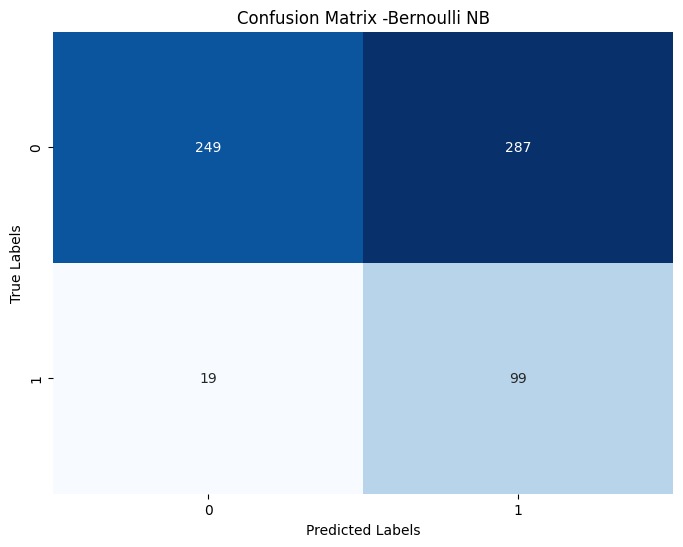

Bernoulli NB Confusion Matrix (Word2Vec)



SVM Train Accuracy (Word2Vec): 0.80
SVM Test Accuracy (Word2Vec): 0.82
SVM Classification Report (Word2Vec):
              precision    recall  f1-score   support

         NOT       0.82      1.00      0.90       536
         OFF       0.00      0.00      0.00       118

    accuracy                           0.82       654
   macro avg       0.41      0.50      0.45       654
weighted avg       0.67      0.82      0.74       654



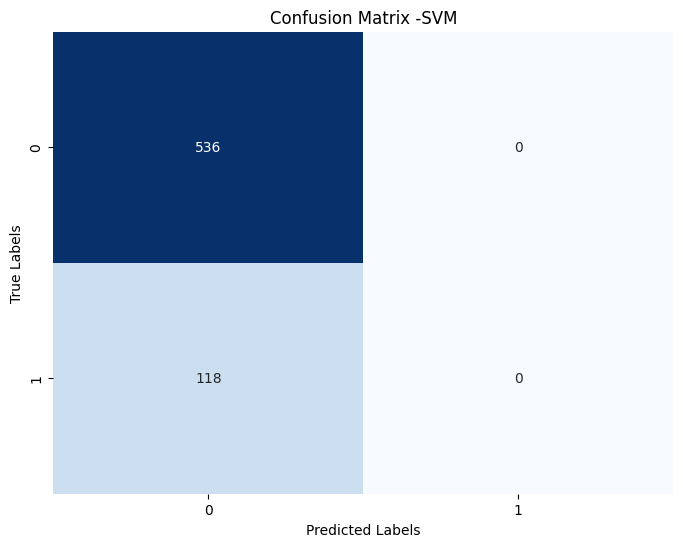

SVM Confusion Matrix (Word2Vec)



Logistic Regression Train Accuracy (Word2Vec): 0.80
Logistic Regression Test Accuracy (Word2Vec): 0.82
Logistic Regression Classification Report (Word2Vec):
              precision    recall  f1-score   support

         NOT       0.82      1.00      0.90       536
         OFF       0.00      0.00      0.00       118

    accuracy                           0.82       654
   macro avg       0.41      0.50      0.45       654
weighted avg       0.67      0.82      0.74       654



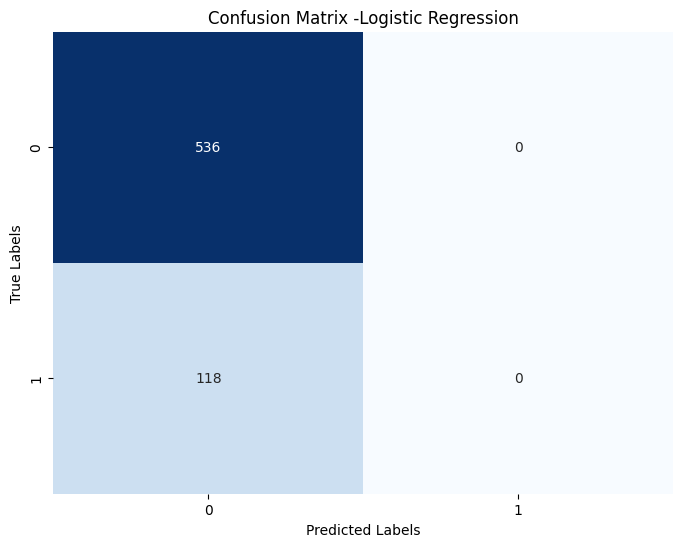

Logistic Regression Confusion Matrix (Word2Vec)



KNN Train Accuracy (Word2Vec): 0.84
KNN Test Accuracy (Word2Vec): 0.81
KNN Classification Report (Word2Vec):
              precision    recall  f1-score   support

         NOT       0.85      0.93      0.89       536
         OFF       0.46      0.28      0.35       118

    accuracy                           0.81       654
   macro avg       0.66      0.60      0.62       654
weighted avg       0.78      0.81      0.79       654



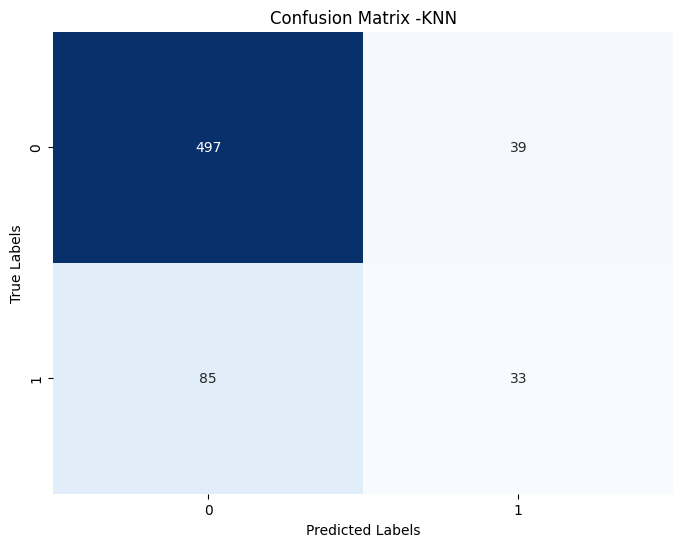

KNN Confusion Matrix (Word2Vec)



RandomForest Train Accuracy (Word2Vec): 1.00
RandomForest Test Accuracy (Word2Vec): 0.83
RandomForest Classification Report (Word2Vec):
              precision    recall  f1-score   support

         NOT       0.83      1.00      0.90       536
         OFF       0.75      0.05      0.10       118

    accuracy                           0.83       654
   macro avg       0.79      0.52      0.50       654
weighted avg       0.81      0.83      0.76       654



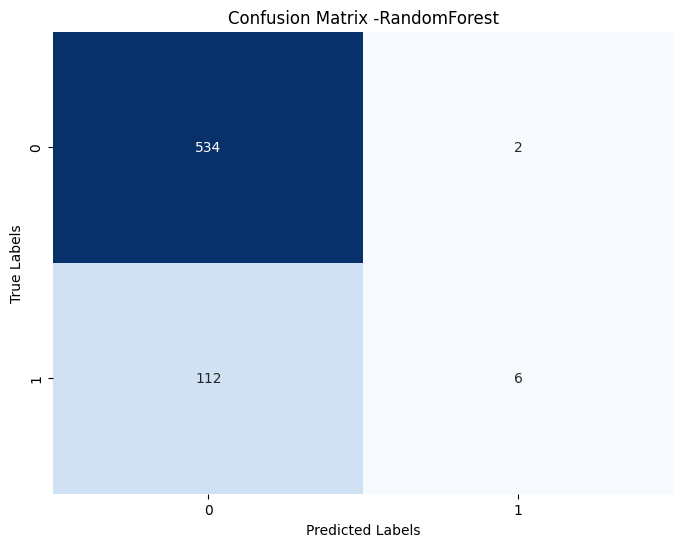

RandomForest Confusion Matrix (Word2Vec)



Decision Tree Train Accuracy (Word2Vec): 1.00
Decision Tree Test Accuracy (Word2Vec): 0.74
Decision Tree Classification Report (Word2Vec):
              precision    recall  f1-score   support

         NOT       0.85      0.83      0.84       536
         OFF       0.31      0.35      0.33       118

    accuracy                           0.74       654
   macro avg       0.58      0.59      0.58       654
weighted avg       0.75      0.74      0.75       654



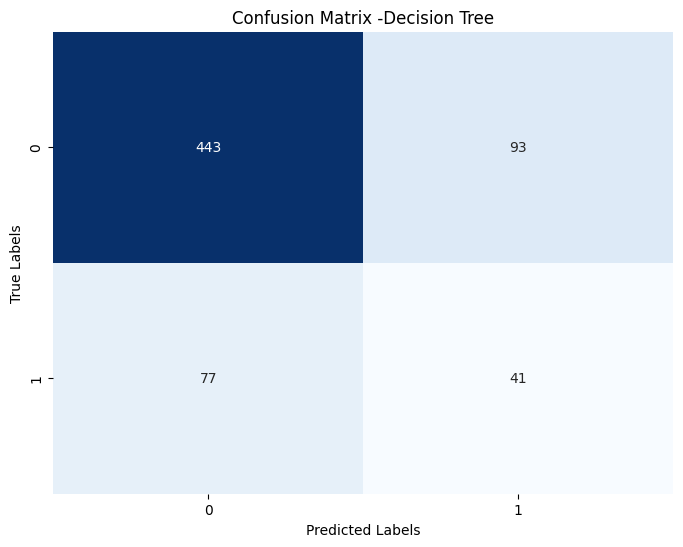

Decision Tree Confusion Matrix (Word2Vec)





In [36]:
# Call the function with the desired feature extraction method
perform_classification("Word2Vec", train_set['text'],test_set['text'], train_set['category'],test_set['category'])

Bernoulli NB Train Accuracy (TF-IDF): 0.83
Bernoulli NB Test Accuracy (TF-IDF): 0.81
Bernoulli NB Classification Report (TF-IDF):
              precision    recall  f1-score   support

         NOT       0.86      0.92      0.89       536
         OFF       0.45      0.31      0.36       118

    accuracy                           0.81       654
   macro avg       0.65      0.61      0.63       654
weighted avg       0.78      0.81      0.79       654



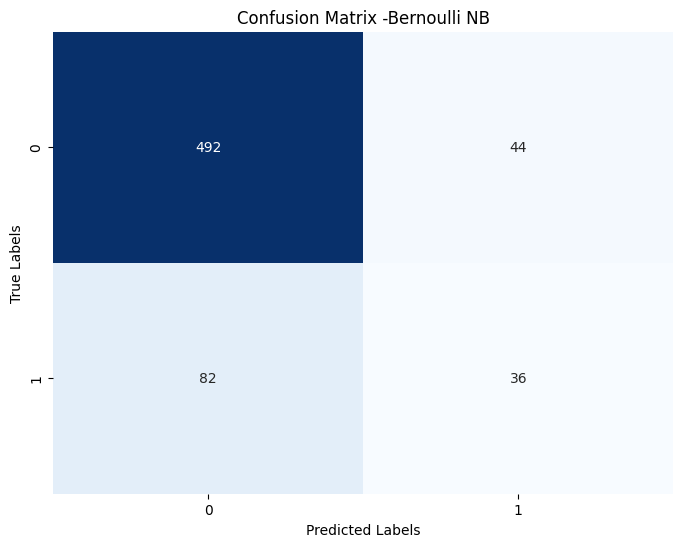

Bernoulli NB Confusion Matrix (TF-IDF)



SVM Train Accuracy (TF-IDF): 0.85
SVM Test Accuracy (TF-IDF): 0.84
SVM Classification Report (TF-IDF):
              precision    recall  f1-score   support

         NOT       0.85      0.98      0.91       536
         OFF       0.67      0.19      0.29       118

    accuracy                           0.84       654
   macro avg       0.76      0.58      0.60       654
weighted avg       0.81      0.84      0.80       654



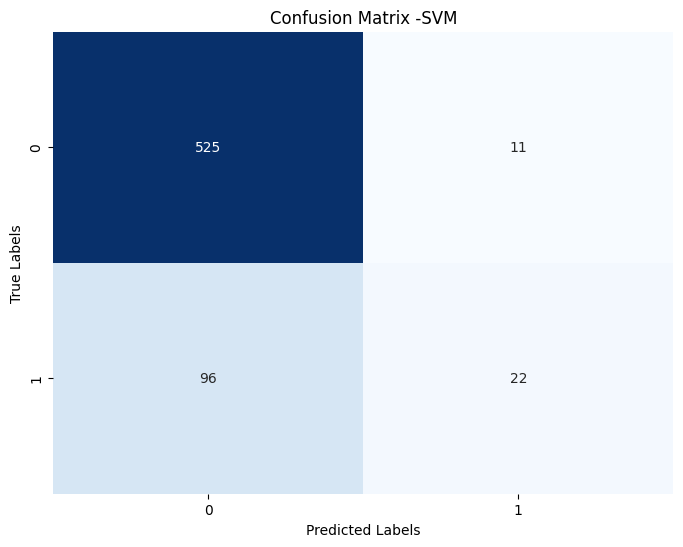

SVM Confusion Matrix (TF-IDF)



Logistic Regression Train Accuracy (TF-IDF): 0.84
Logistic Regression Test Accuracy (TF-IDF): 0.84
Logistic Regression Classification Report (TF-IDF):
              precision    recall  f1-score   support

         NOT       0.85      0.97      0.91       536
         OFF       0.66      0.25      0.36       118

    accuracy                           0.84       654
   macro avg       0.76      0.61      0.63       654
weighted avg       0.82      0.84      0.81       654



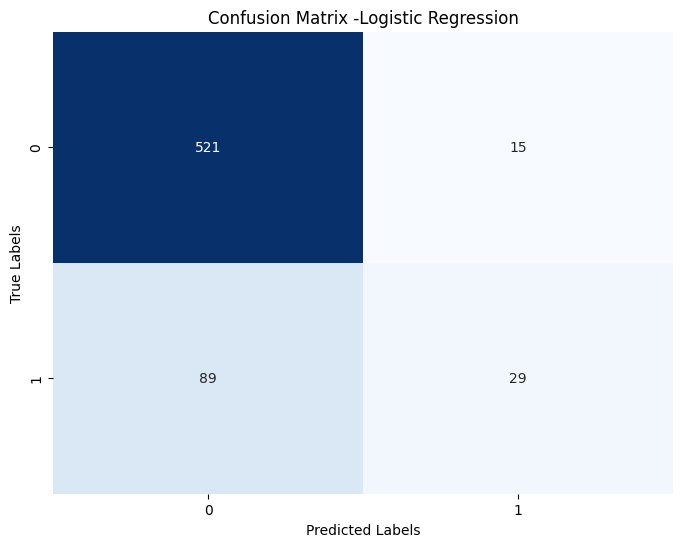

Logistic Regression Confusion Matrix (TF-IDF)



KNN Train Accuracy (TF-IDF): 0.83
KNN Test Accuracy (TF-IDF): 0.82
KNN Classification Report (TF-IDF):
              precision    recall  f1-score   support

         NOT       0.83      0.99      0.90       536
         OFF       0.50      0.05      0.09       118

    accuracy                           0.82       654
   macro avg       0.66      0.52      0.50       654
weighted avg       0.77      0.82      0.75       654



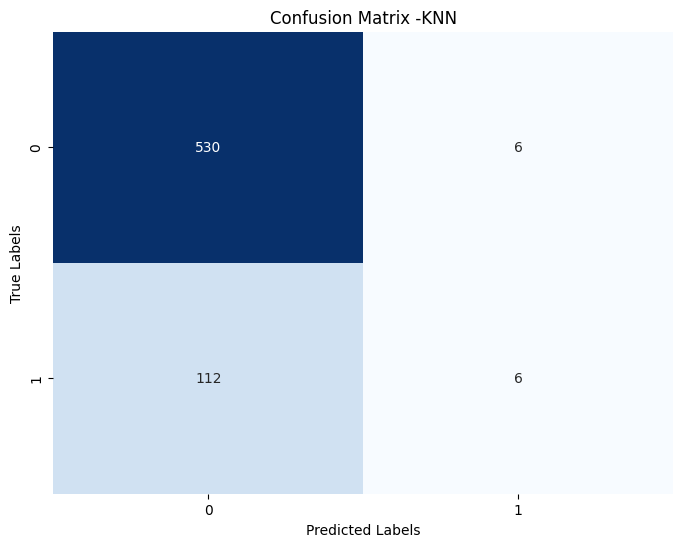

KNN Confusion Matrix (TF-IDF)



RandomForest Train Accuracy (TF-IDF): 1.00
RandomForest Test Accuracy (TF-IDF): 0.83
RandomForest Classification Report (TF-IDF):
              precision    recall  f1-score   support

         NOT       0.83      0.99      0.90       536
         OFF       0.69      0.08      0.14       118

    accuracy                           0.83       654
   macro avg       0.76      0.53      0.52       654
weighted avg       0.81      0.83      0.77       654



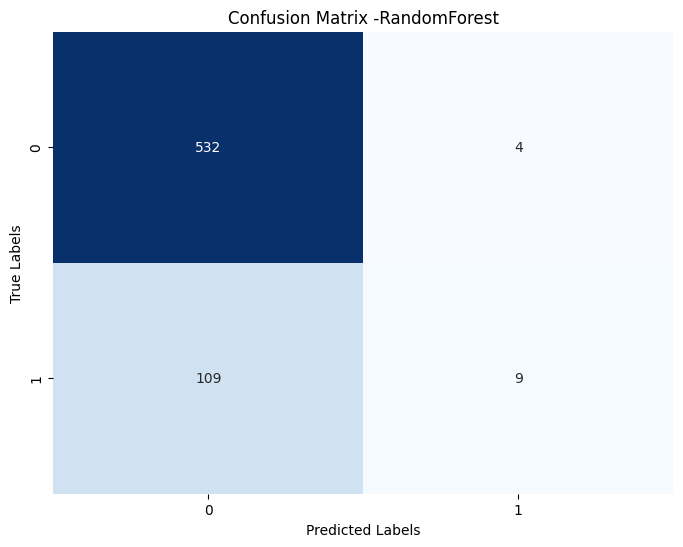

RandomForest Confusion Matrix (TF-IDF)



Decision Tree Train Accuracy (TF-IDF): 1.00
Decision Tree Test Accuracy (TF-IDF): 0.78
Decision Tree Classification Report (TF-IDF):
              precision    recall  f1-score   support

         NOT       0.85      0.88      0.87       536
         OFF       0.37      0.32      0.34       118

    accuracy                           0.78       654
   macro avg       0.61      0.60      0.60       654
weighted avg       0.77      0.78      0.77       654



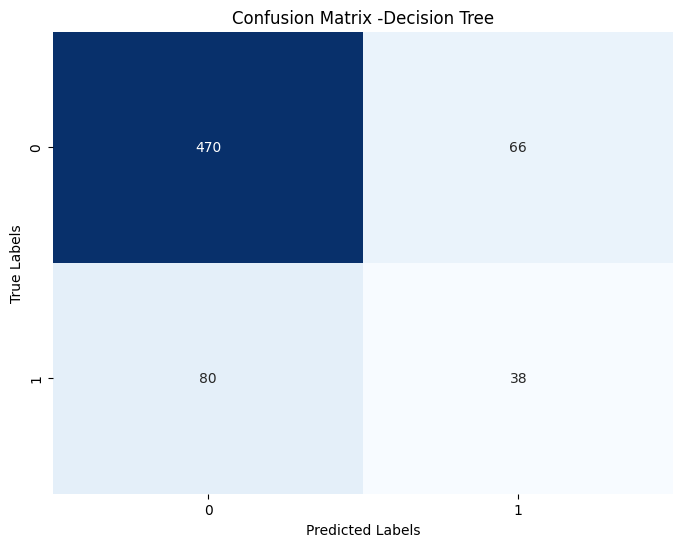

Decision Tree Confusion Matrix (TF-IDF)





In [37]:
# After Add stop word
perform_classification("TF-IDF",train_set['text'],test_set['text'], train_set['category'],test_set['category'])

Bernoulli NB Train Accuracy (BOW): 0.83
Bernoulli NB Test Accuracy (BOW): 0.81
Bernoulli NB Classification Report (BOW):
              precision    recall  f1-score   support

         NOT       0.86      0.92      0.89       536
         OFF       0.45      0.31      0.36       118

    accuracy                           0.81       654
   macro avg       0.65      0.61      0.63       654
weighted avg       0.78      0.81      0.79       654



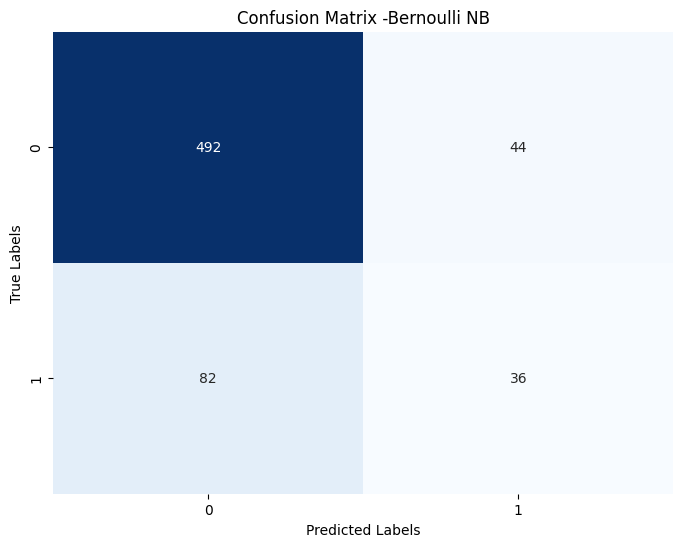

Bernoulli NB Confusion Matrix (BOW)



SVM Train Accuracy (BOW): 0.91
SVM Test Accuracy (BOW): 0.84
SVM Classification Report (BOW):
              precision    recall  f1-score   support

         NOT       0.86      0.95      0.91       536
         OFF       0.59      0.32      0.42       118

    accuracy                           0.84       654
   macro avg       0.73      0.64      0.66       654
weighted avg       0.82      0.84      0.82       654



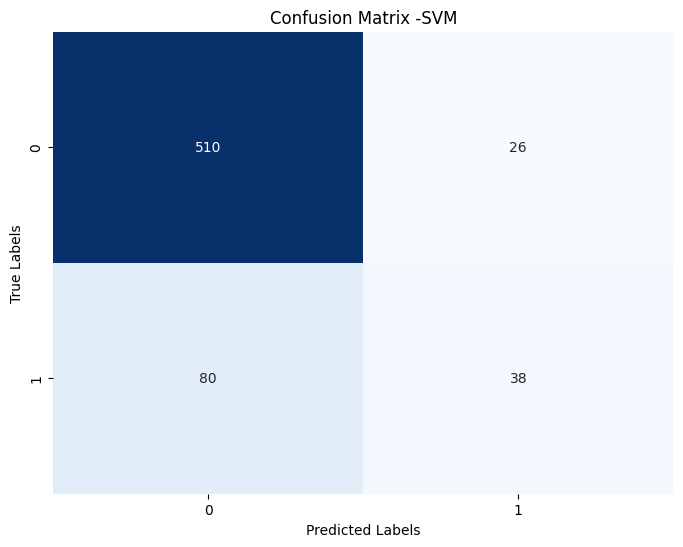

SVM Confusion Matrix (BOW)





/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Train Accuracy (BOW): 0.88
Logistic Regression Test Accuracy (BOW): 0.84
Logistic Regression Classification Report (BOW):
              precision    recall  f1-score   support

         NOT       0.87      0.95      0.91       536
         OFF       0.59      0.35      0.44       118

    accuracy                           0.84       654
   macro avg       0.73      0.65      0.67       654
weighted avg       0.82      0.84      0.82       654



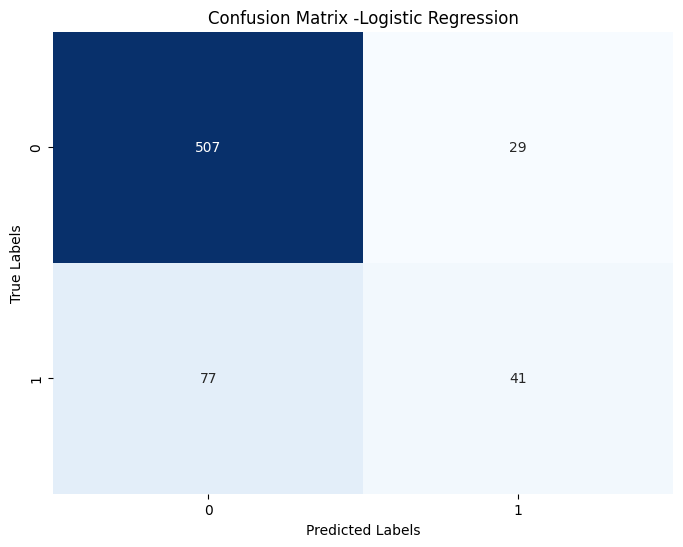

Logistic Regression Confusion Matrix (BOW)



KNN Train Accuracy (BOW): 0.84
KNN Test Accuracy (BOW): 0.82
KNN Classification Report (BOW):
              precision    recall  f1-score   support

         NOT       0.83      0.98      0.90       536
         OFF       0.46      0.09      0.15       118

    accuracy                           0.82       654
   macro avg       0.64      0.53      0.53       654
weighted avg       0.76      0.82      0.76       654



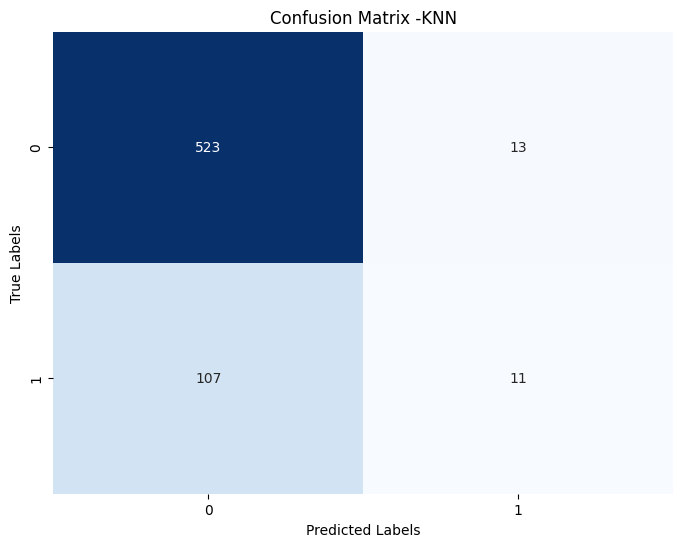

KNN Confusion Matrix (BOW)



RandomForest Train Accuracy (BOW): 1.00
RandomForest Test Accuracy (BOW): 0.83
RandomForest Classification Report (BOW):
              precision    recall  f1-score   support

         NOT       0.84      0.99      0.91       536
         OFF       0.73      0.14      0.23       118

    accuracy                           0.83       654
   macro avg       0.78      0.56      0.57       654
weighted avg       0.82      0.83      0.79       654



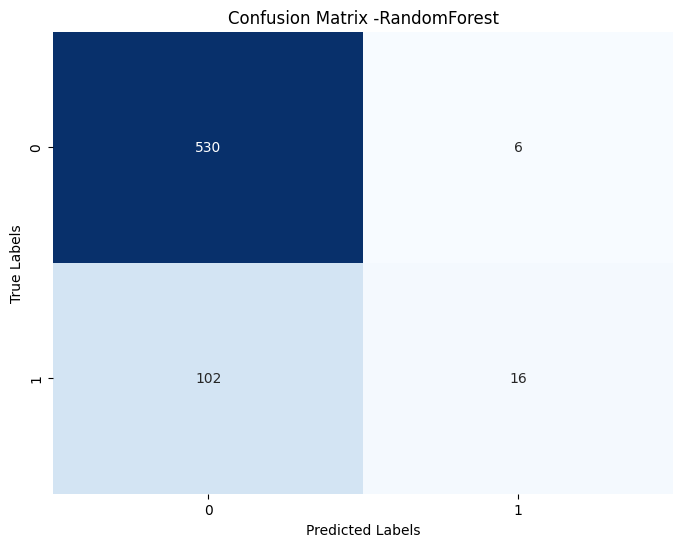

RandomForest Confusion Matrix (BOW)



Decision Tree Train Accuracy (BOW): 1.00
Decision Tree Test Accuracy (BOW): 0.79
Decision Tree Classification Report (BOW):
              precision    recall  f1-score   support

         NOT       0.87      0.88      0.87       536
         OFF       0.41      0.39      0.40       118

    accuracy                           0.79       654
   macro avg       0.64      0.63      0.64       654
weighted avg       0.78      0.79      0.79       654



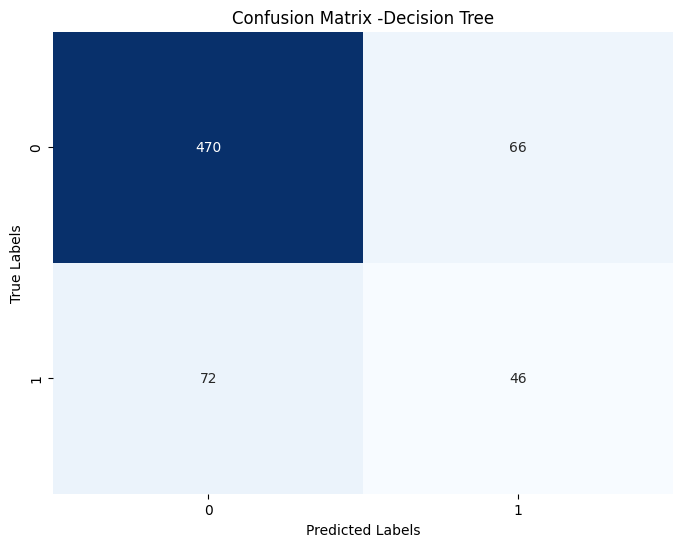

Decision Tree Confusion Matrix (BOW)





In [38]:
# Before add stop word
perform_classification("BOW",train_set['text'],test_set['text'], train_set['category'],test_set['category'])